# Module 2 Final Project - How Does Discount Impact Sales? 


### Northwind Database

<img src='Northwind_ERD.png'>

In [1]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pylab
%matplotlib inline

from IPython.display import display, HTML

from scipy import stats
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import statsmodels.stats.api as sms
from statsmodels.regression.linear_model import OLSResults
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.formula.api as smf
import category_encoders as ce
from statsmodels.stats.power import TTestIndPower, FTestPower, FTestAnovaPower
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats.mstats import gmean

from patsy.contrasts import Sum
from patsy.contrasts import Helmert
from patsy.contrasts import Treatment
from patsy import dmatrices


In [2]:
# Functions 
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for col in cols_list:
        print("Name: {} \t Type: {}".format(col['name'], col['type']))
        
def z_hbar(data, y_col, x_col, xlabel, title):
    colors = sns.color_palette("GnBu_d", 10)
    plt.figure(figsize=(8,7))
    ax = sns.barplot(y = data[y_col], x = data[x_col], data=data, orient='h', palette=colors, errwidth=0.8,
           capsize=0.2)
    ax.set_xlabel(xlabel=xlabel, fontsize=14)
    ax.set_xticks(np.arange(-0.5, 1.5))
    ax.set_ylabel(ylabel='Participants', fontsize=14)
    ax.set_title(label=title, fontsize=17)
    plt.tight_layout();
    
def boxplot(data, x, y, xlabel, ylabel, title):
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
    fig, axes = plt.subplots(1, figsize=(9,6))
    sns.boxplot(x=x, y=y, data=data, ax=axes, palette=("husl"), boxprops=dict(alpha=.8), 
                showmeans=True, meanprops=meanpointprops)
    sns.swarmplot(x=x, y=y, data=data, color="grey", alpha=0.6)
    plt.xticks(fontsize=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14);
    
# Test for power based on sample and expected effect size
def power(df_num, df_denom, alpha, effect):
    return FTestPower().solve_power(effect_size=effect, df_num=df_num, df_denom=df_denom, alpha=alpha)


In [3]:
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=False)
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)
con = engine.connect()
metadata = MetaData()

In [4]:
product = pd.read_sql_query("""
SELECT o.EmployeeId, o.ShipRegion, od.Quantity, od.Discount, od.UnitPrice, o.Freight, 
        c.Id as CategoryId, c.CategoryName, ((p.UnitPrice * od.Quantity * (1 - od.Discount)) - Freight) as Revenue, 
        (p.UnitPrice * od.Quantity) as SalePrice
       
FROM [Order] o
    join OrderDetail od
    on od.OrderID = o.ID
    
    JOIN Product p
    on od.ProductID = p.ID
    
    JOIN Category c 
    on c.ID = p.CategoryID  

""", engine)              


In [5]:
product.head()

,EmployeeId,ShipRegion,Quantity,Discount,UnitPrice,Freight,CategoryId,CategoryName,Revenue,SalePrice
0,5,Western Europe,12,0.0,14.0,32.38,4,Dairy Products,219.62,252.00
1,5,Western Europe,10,0.0,9.8,32.38,5,Grains/Cereals,107.62,140.00
2,5,Western Europe,5,0.0,34.8,32.38,4,Dairy Products,141.62,174.00
3,6,Western Europe,9,0.0,18.6,11.61,7,Produce,197.64,209.25
4,6,Western Europe,40,0.0,42.4,11.61,7,Produce,2108.39,2120.00


# Variables of Interest

## Discount

The figure below shows that Discount is primarily categorical. Therefore, it was binned into a Binary variable and into a more granulated Group variable (ordinal, with bins of 5%) for analysis. 

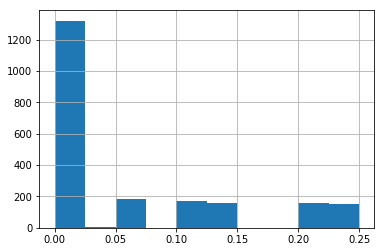

In [6]:
product.Discount.hist();

In [7]:
# Binary Discount 
product.loc[product['Discount'] == 0.0, 'DiscountBinary'] = 0
product.loc[product['Discount'] > 0.0, 'DiscountBinary'] = 1

# Binned Groups of 5%
product.loc[product['Discount'] == 0.0, 'DiscountGrouped'] = 0
product.loc[(product['Discount'] > 0.0) & (product['Discount'] <= 0.05), 'DiscountGrouped'] = 1
product.loc[(product['Discount'] > 0.05) & (product['Discount'] <= 0.10), 'DiscountGrouped'] = 2
product.loc[(product['Discount'] > 0.10) & (product['Discount'] <= 0.15), 'DiscountGrouped'] = 3
product.loc[(product['Discount'] > 0.15) & (product['Discount'] <= 0.20), 'DiscountGrouped'] = 4
product.loc[(product['Discount'] > 0.20) & (product['Discount'] <= 0.25), 'DiscountGrouped'] = 5

## Sales Price

To further evaluate whether:

i) Offering discounts benefits sales
ii) What level of discount best benefits sales

Sales Price was used as the outcome variable. Sales Price was feature engineered from **Unit Price * Quantity**, and therefore contains information about quantity as well as overall value of the sale. This may therefore be a more informative metric for decision making with regards to what discount to offer customers in the future. 

Since Sales is positively skewed, it may be lognormally distributed (https://www.investopedia.com/terms/n/normaldistribution.asp)

# 1) Lognormal Distribution of Sales Prices

C:\Users\Danyal\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


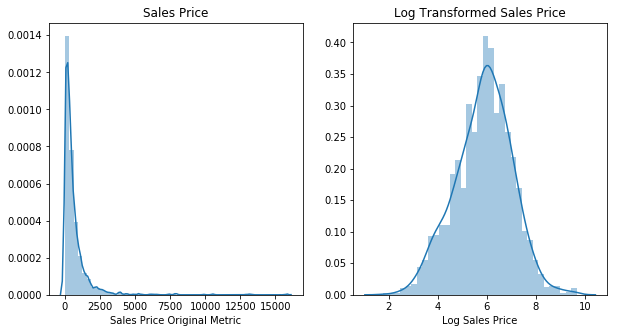

In [8]:
# The log transformed Sales Price indicates a relatively lognormal distribution 

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

sns.distplot(product.SalePrice, ax=ax1)
sns.distplot(np.log(product.SalePrice), ax=ax2);

ax1.set_title('Sales Price')
ax2.set_title('Log Transformed Sales Price')

#ax1.xaxis.label.set_visible(False)
ax1.xaxis.set_label_text('Sales Price Original Metric')
ax2.xaxis.set_label_text('Log Sales Price')

product['LogSales'] = np.log(product.SalePrice)

In [9]:
print('Log Sales\n', product.SalePrice.describe().round(2),end='\n\n')
print('Original Scale Sales\n', product.LogSales.describe().round(2))

Log Sales
 count     2155.00
mean       672.56
std       1110.26
min          6.00
25%        170.50
50%        380.00
75%        760.00
max      15810.00
Name: SalePrice, dtype: float64

Original Scale Sales
 count    2155.00
mean        5.86
std         1.16
min         1.79
25%         5.14
50%         5.94
75%         6.63
max         9.67
Name: LogSales, dtype: float64


In [10]:
# normality for log transformed Sales Price confirmed with Shapiro-Wilks
stats.shapiro(product.LogSales)

(0.9954862594604492, 4.2462002056709025e-06)

## Significance Testing and Log Sales

Sales Price was log transformed and the logarithmic mean was used for significance testing. If we convert the logarithmic mean back into our original scale, we create geometric means (https://medium.com/@JLMC/understanding-three-simple-statistics-for-data-visualizations-2619dbb3677a), which are the anti-logs of the mean of the logged data. 

Furthermore, the coefficients must be interpreted as ratios rather than differences when converted back into the original metric. 

The exponentiated coefficient can be interpreted as the ratio of the expected geometric mean for one group compared with the expected geometric mean of the relative reference group(s). Marginal changes in the explanatory variables are interpreted in terms of multiplicative (percentage) changes in the dependent variable. 

In [11]:
# Functions for converting the regression coefficients for interpretation 
def geo_mean_convert(B):
    # natural log of the input
    # exponentiation is inverse of logarithm 
    return round(np.exp(B), 2)

def geomean_ratio(coefficient, ref, group):
    # ratios of the natural logs for interpretation of the regression coefficients
    ratio = round(np.exp(coefficient), 2)
    print('The geometric mean of {} is {} times {}'.format(group.title(), ratio, ref.title()))
    if ratio > 1:
          print('The geometric mean of {} is {}% more than {}'.format(group.title(), 
                round(ratio%1*100, 0), ref.title()))      
    else:
          print('The geometric mean of {} is {}% less than {}'.format(group.title(), 
                round((1 - ratio%1)*100, 2), ref.title()))
      
#def ci_geometric_ratio(lower, upper):
                
def geo_means(data, x, y):
    # Summary statistics including geometric means for comparison
    groups = sorted(list(data[x].unique()))
    geo_mean = [round(gmean(data.loc[data[x] == group][y]), 2) for group in groups]
    median = [round((data.loc[data[x] == group][y].median()), 2) for group in groups] 
    amean = [round(data.loc[data[x] == group][y].mean(), 2) for group in groups]
    df = pd.DataFrame({x:groups, 'geo_mean': geo_mean, 'median': median, 'mean': amean})
    return df

gmean(product.loc[product['DiscountBinary'] == 0.0]['SalePrice'])
product.groupby('DiscountBinary').median()

,EmployeeId,Quantity,Discount,UnitPrice,Freight,CategoryId,Revenue,SalePrice,DiscountGrouped,LogSales
DiscountBinary,,,,,,,,,,
0.0,4,18,0.00,18.4,47.46,4,276.8400,357.5,0.0,5.879135
1.0,4,20,0.15,18.0,60.18,4,303.6175,440.8,3.0,6.088590


## Discount and Sales

A series of OLS models using _LogSales_ were run; the models were not complete since the aim was not overall predictive accuracy, but rather establishing relationships (or lack thereof) between variables. Since the F-test of the OLS model is identical to ANOVA, OLS was preferred for it's enhanced flexibility (ability to combine categorical and continuous variables), improved robustness, and better diagnostic/influence tests. 

The _F-test_ evaluates the significance of $R_2$ compared to the null (nil) hypothesis, (i.e., that $R_2$ is 0). $R_2$ also doubles as an effect size. 
 

**Hypotheses:**

$H_0$: **Discount does not significantly impact Sales Price**

$H_1$: **Discount does significantly impact Sales Price**


In [12]:
# Dummy contrast matrix for OLS group comparisons 

levels = [i for i in range(0, len(set(product.DiscountGrouped)))]
levels1 = [i for i in range(2)]

# Discount = None (index 0) is set as the reference group; all levels of discount will be compared to no discount
dummy_contrast = Treatment(reference=0).code_without_intercept(levels)
dummy_con_binary = Treatment(reference=0).code_without_intercept(levels1)

print(dummy_contrast.matrix)

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [13]:
# No Discount vs Discount regressed on Log Sales
lm = smf.ols('LogSales ~ C(DiscountBinary)', data = product).fit(cov_type='HC3')
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     22.44
Date:                Sat, 12 Jan 2019   Prob (F-statistic):           2.31e-06
Time:                        11:25:56   Log-Likelihood:                -3375.0
No. Observations:                2155   AIC:                             6754.
Df Residuals:                    2153   BIC:                             6765.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [14]:
# The geometric mean is not identical to the median because the data is not perfectly lognormal 
geo_means(product, 'DiscountBinary', 'SalePrice')

,DiscountBinary,geo_mean,median,mean
0,0.0,319.01,357.5,606.96
1,1.0,406.96,440.8,775.66


In [15]:
# The anti-log for the sum of the intercept and coefficient is the geomean for the Discount group (as confirmed above) 
print('Geometric mean Sales Price for Discount:', geo_mean_convert((0.2435 + 5.7652)))

# The intercept gives the geometric mean for the No Discount Group
print('Geometric mean Sales Price for No Discount:', geo_mean_convert(5.7652))

# Using only the coefficient gives the ratio between geometric means
print('Ratio between geometric mean values:', geo_mean_convert(0.2435))

Geometric mean Sales Price for Discount: 406.95
Geometric mean Sales Price for No Discount: 319.0
Ratio between geometric mean values: 1.28


In [16]:
# The ratio between geometric means is further explored:
geomean_ratio(0.2435, 'no discount', 'discount')

The geometric mean of Discount is 1.28 times No Discount
The geometric mean of Discount is 28.0% more than No Discount


## INTERPRETATION


Interpreting the main effect of discount, the intercept $B_0$ is the mean _Log Sales Price_ for the _no discount_ (reference) category. The coefficient for Discount indicates the ratio between the geometric mean of the discount and no discount group. To clarify, the ratio of geometric means is 1.28:1 for discount : no discount, or the geometric mean of Sales for discount (_GM_ = 406.95) is 28% higher than no discount (_GM_ = 319.0). 

Discount significantly increased sales compared with no discount. Therefore, we fail to reject the null and accept that offering a discount did increase Sales. 

**Follow Up Hypotheses:**

$H_0$: **All levels of discount are equal with regards to Sales Price**

$H_1$: **Levels of discount differ with regards to Sales Price**

In [17]:
# Contrast only discount categories

discount = product.loc[product['DiscountGrouped'] > 0]

levels = [i for i in range(0, len(set(discount.DiscountGrouped)))]

# Sum contrast for discount - each group is compared to the unweighted mean of all other groups
sum_con_disc = Sum(omit=0).code_without_intercept(levels)

print(sum_con_disc.matrix)

[[-1. -1. -1. -1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [18]:
# Each discount group is compared to the no discount group
# The intercept represents the log mean Sales for the no discount group
lm = smf.ols('LogSales ~ C(DiscountGrouped)', data = product).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     5.149
Date:                Sat, 12 Jan 2019   Prob (F-statistic):           0.000106
Time:                        11:25:56   Log-Likelihood:                -3373.4
No. Observations:                2155   AIC:                             6759.
Df Residuals:                    2149   BIC:                             6793.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [19]:
geo_means(product, 'DiscountGrouped', 'SalePrice')

,DiscountGrouped,geo_mean,median,mean
0,0.0,319.01,357.5,606.96
1,1.0,409.82,426.0,856.43
2,2.0,365.63,397.5,640.90
3,3.0,413.40,450.0,702.65
4,4.0,398.80,397.5,767.93
5,5.0,457.67,482.5,909.75


In [20]:
# Each discount group is compared to the unweighted mean of all other groups
# The intercept represents the unweighted log mean Sales for all discount groups
lm = smf.ols('LogSales ~ C(DiscountGrouped, sum_con_disc)', data = discount).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7741
Date:                Sat, 12 Jan 2019   Prob (F-statistic):              0.542
Time:                        11:25:56   Log-Likelihood:                -1317.6
No. Observations:                 838   AIC:                             2645.
Df Residuals:                     833   BIC:                             2669.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

## INTERPRETATION OF LEVELS OF DISCOUNT ON SALES

A sum contrast was used to compare each level of discount with all other levels (i.e., the geometric mean for each level of discount was compared with the combined geometric mean for all other levels). Significance testing indicated that level of discount accounted for no variance/ effect in LogSales, _F = 0.6577, p = 0.54_. Therefore, individual contrasts will not be investigated further and we can conclude that, while some discount is significantly related to Sales, the level of discount is inconsequential. We therefore fail to reject the null, and accept that all levels of discount are equal with regards to Sales. 


## CONCLUSION

The above two analyses indicated that, on average, Sales Price was 28% higher when a discount was offered. While almost all discount groups differed significantly from no discount, the amount of discount offered did not significantly impact Sales Price. Therefore, based on these analyses we can consider offering a discount of 1 - 5%. 

Discounts > 5% = 87 448.93 Euros, or 6.03% of total sales. Therefore, this could potentially be saved if smaller discounts are as effective as larger ones in increasing the number of items ordered/ overall price of the sale. 


In [21]:
# to calculate savings figures above

#savings = product.loc[product['DiscountGrouped'] > 1]
#discounts = savings.Discount * savings.SalePrice
#(discounts.sum()/ product.SalePrice.sum()) * 100

## FOLLOW UP ANALYSES:

Before any final recommendations with regards to discount can be made, it is necessary to understand how discount may affect Sales Price for various Categories of product, Regions of Sale, or Employees. 



# CATEGORY

There are 8 categories of product. It is possible that between- and within-category effects differ from the overall effects seen in the previous analysis.  

In particular, it is important whether any interactions between category and discount exist (i.e., partialed effects - contribution to $R_2$ over and above the main effects of discount and category on Sales).

In this instance _Category_ is a fixed effect as it represents all categories of product available for this company and our conclusions apply only to these conditions of discount and category. Therefore, the interactions test the hypotheses:

$H_0$: **Discount uniformly affects Sales for all categories of product (Geo.means equal)**

$H_1$: **Discount does not uniformly affect Sales for all categories of product (Geo.means not equal)**

This analysis will help to refine our decisions regarding:
i) Whether offering discounts benefits sales
ii) What level of discount best benefits sales

Should we find that sales within certain categories are more or less affected by discount, and specific levels of discount, this will allow a more nuanced approach to discount. 

In [22]:
# Descriptives for each level of Discount and Category
print(product.groupby(['CategoryName', 'DiscountGrouped'])['SalePrice'].agg(['mean','std', 'median', min, max]).round(2))

                                   mean      std   median     min       max
CategoryName   DiscountGrouped                                             
Beverages      0.0               661.52  1750.66   252.00   13.50  15810.00
               1.0              1872.04  3478.37   438.75   36.00  15810.00
               2.0               613.27   851.77   360.00   62.00   3952.50
               3.0               455.35   381.47   360.00   36.00   1656.00
               4.0              1102.97  2841.22   325.50   45.00  13175.00
               5.0               732.34  1837.94   360.00   27.00  10540.00
Condiments     0.0               492.00   470.18   400.00   17.00   2853.50
               1.0               668.10   536.12   421.02   25.00   1945.00
               2.0               471.93   367.88   396.00   26.00   1684.00
               3.0               830.15   970.64   364.00   38.90   3512.00
               4.0               585.35   406.56   433.75   26.00   1387.75
            

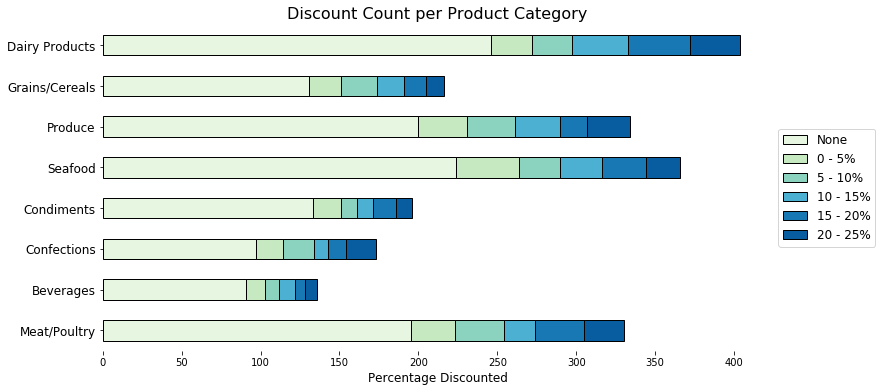

In [23]:
discount = product.groupby('CategoryName')['DiscountGrouped'].value_counts().unstack('DiscountGrouped')

discount.plot(kind='barh', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
              figsize=(12,6), edgecolor = "black")

plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(np.arange(8), (['Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood',
       'Condiments', 'Confections', 'Beverages', 'Meat/Poultry']), fontsize=12)
plt.xlabel('Percentage Discounted', fontsize=12)
plt.legend(('None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'), fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Discount Count per Product Category', fontsize=16);
sns.despine(left=True, bottom=True)

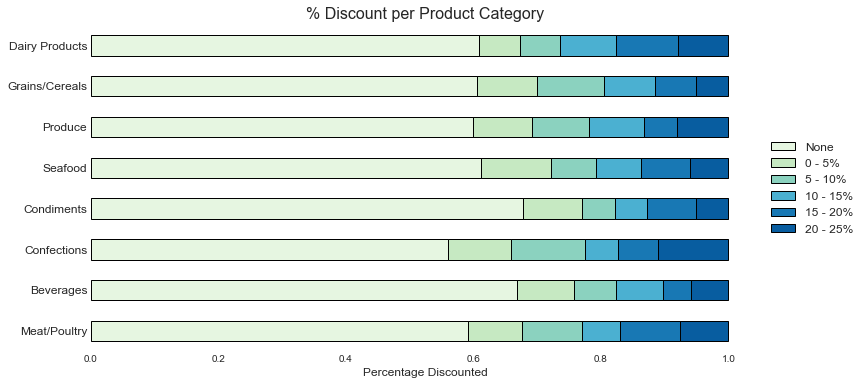

In [24]:
plt.style.use('seaborn-white')

discount = product.groupby('CategoryName')['DiscountGrouped'].value_counts(normalize=True).unstack('DiscountGrouped')

discount.plot(kind='barh', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
              figsize=(12,6), edgecolor = "black")

plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(np.arange(8), (['Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood',
       'Condiments', 'Confections', 'Beverages', 'Meat/Poultry']), fontsize=12)
plt.xlabel('Percentage Discounted', fontsize=12)
plt.legend(('None', '0 - 5%', '5 - 10%', '10 - 15%', '15 - 20%', '20 - 25%'), fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('% Discount per Product Category', fontsize=16);
sns.despine(left=True, bottom=True)

In [25]:
levels = [i for i in range(len(set(product.CategoryId)))]
levels1 = [i for i in range(len(set(product.DiscountGrouped)))]

sum_con_cat = Sum(omit=0).code_without_intercept(levels)
dummy_con_cat = Treatment(reference=0).code_without_intercept(levels)
sum_con_disc = Sum().code_without_intercept(levels1)

print('Sum Contrast Matrix - Categories\n', sum_con_cat.matrix, end='\n\n')
print('Dummy Contrast Matrix - Categories\n', dummy_con_cat.matrix, end='\n\n')
print('Sum Contrast Matrix - Discount\n', sum_con_disc.matrix)

Sum Contrast Matrix - Categories
 [[-1. -1. -1. -1. -1. -1. -1.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.]]

Dummy Contrast Matrix - Categories
 [[0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]

Sum Contrast Matrix - Discount
 [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [-1. -1. -1. -1. -1.]]


In [26]:
# Category sample sizes
product.groupby(['CategoryId'])['CategoryName'].value_counts()

CategoryId  CategoryName  
1           Beverages         404
2           Condiments        216
3           Confections       334
4           Dairy Products    366
5           Grains/Cereals    196
6           Meat/Poultry      173
7           Produce           136
8           Seafood           330
Name: CategoryName, dtype: int64

In [27]:
discount = product.loc[product['DiscountGrouped'] > 0]

levels = [i for i in range(0, len(set(discount.DiscountGrouped)))]

sum_con_disc = Sum(omit=4).code_without_intercept(levels)

print(sum_con_disc.matrix)

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [-1. -1. -1. -1.]]


In [44]:
# The interactions between each category and level of discount was of interest; in particualr, whether any category was a 
# significant exception to the conclusion above that discounts higher than 5% are not necessary to increase sales. 

lm = smf.ols('LogSales ~ C(DiscountGrouped, sum_con_disc) * C(CategoryName, sum_con_cat)', data = discount).fit()

print(lm.summary(), end='\n\n')
print('C(DiscountGrouped)[T.1.0]:C(CategoryName, sum_con_cat)[S.7]  -261.0766    138.203     -1.889      0.059    -531.950       9.797'
'C(DiscountGrouped)[T.2.0]:C(CategoryName, sum_con_cat)[S.7]   -51.0310     95.611     -0.534      0.594    -238.425     136.363'
"C(DiscountGrouped)[T.3.0]:C(CategoryName, sum_con_cat)[S.7]    75.0655    157.194      0.478      0.633    -233.029     383.160"
'C(DiscountGrouped)[T.4.0]:C(CategoryName, sum_con_cat)[S.7]   220.7109    142.485      1.549      0.121     -58.555     499.976'
'C(DiscountGrouped)[T.5.0]:C(CategoryName, sum_con_cat)[S.7]  -222.4185    139.436     -1.595      0.111    -495.708      50.871')

                            OLS Regression Results                            
Dep. Variable:               LogSales   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.597
Date:                Sat, 12 Jan 2019   Prob (F-statistic):             0.0127
Time:                        11:28:22   Log-Likelihood:                -1287.7
No. Observations:                 838   AIC:                             2655.
Df Residuals:                     798   BIC:                             2845.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [40]:
# The intercept gives the unweighted geometric mean for the No Discount Group conditioned on every category
print('Sales Price for unweighted Geo. Mean of No Discount for all categories:', geo_mean_convert(5.8231))

# The anti-log for the Beverages * 1-5% discount interaction 
print('Sales Price for Beverages * 1-5% discount:', geo_mean_convert((0.5698 + 5.8231)))

# The anti-log for the Confections * 10-15% discount interaction 
print('Sales Price for Confections * 10-15% discount:', geo_mean_convert((0.0080 + 5.8231)))

# using only the coefficient gives the ratio between geometric means
print('1 :', geo_mean_convert(0.5698))

# using only the coefficient gives the ratio between geometric means
print('Ratio between median values:', geo_mean_convert(0.0080))

Sales Price for unweighted Geo. Mean of No Discount for all categories: 338.02
Sales Price for Beverages * 1-5% discount: 597.59
Sales Price for Confections * 10-15% discount: 340.73
1 : 1.77
Ratio between median values: 1.01


In [30]:
geomean_ratio(0.5698, 'No Discount all categories', 'Beverages discount 1 - 5%')

The geometric mean of Beverages Discount 1 - 5% is 1.77 times No Discount All Categories
The geometric mean of Beverages Discount 1 - 5% is 77.0% more than No Discount All Categories


In [31]:
geomean_ratio(0.0080, 'No Discount all categories', 'Confections discount 10 - 15%')

The geometric mean of Confections Discount 10 - 15% is 1.01 times No Discount All Categories
The geometric mean of Confections Discount 10 - 15% is 1.0% more than No Discount All Categories


Further investigation before final decision:
1) Is the effect of discount on Sales Price modulated by time? In other words, does offering larger discounts earlier on result in more sales over time for any customers? 

### REFERENCES 

https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/

https://stats.stackexchange.com/questions/163518/interpreting-test-results-on-log-transformed-data

http://www.jerrydallal.com/LHSP/ci_logs.htm

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-do-i-interpret-a-regression-model-when-some-variables-are-log-transformed/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/

https://blog.stata.com/2011/08/22/use-poisson-rather-than-regress-tell-a-friend/

https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va/3530#3530

Cohen (2013). Applied Multiple Regression/Correlation Analysis for the Behavioral Sciences. 